
# **Initial Data cleaning and quality check** 

Procedures:
* Load and Inspect Dataset(.parquet)
* Clean data
* Summary and Descriptive Statistics




In [24]:
# importing libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


## Loading and Inspecting

In [6]:
df = pd.read_parquet("processed/flights_2020_2025_cleaned.parquet")
df.head()

,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,Cancelled,Diverted,AirTime,Distance
0,2020-01-09,B6,BOS,CLT,900.0,0846,-14.0,1135.0,1108,-27.0,0.0,0.0,0.0,112.0,728.0
1,2020-01-10,B6,BOS,CLT,900.0,0845,-15.0,1135.0,1056,-39.0,0.0,0.0,0.0,114.0,728.0
2,2020-01-12,B6,BOS,CLT,900.0,0850,-10.0,1135.0,1137,2.0,2.0,0.0,0.0,130.0,728.0
3,2020-01-13,B6,BOS,CLT,900.0,0846,-14.0,1135.0,1111,-24.0,0.0,0.0,0.0,127.0,728.0
4,2020-01-14,B6,BOS,CLT,900.0,0851,-9.0,1135.0,1133,-2.0,0.0,0.0,0.0,134.0,728.0


In [7]:
# data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13561830 entries, 0 to 13561829
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FlightDate         datetime64[ns]
 1   Reporting_Airline  string        
 2   Origin             string        
 3   Dest               string        
 4   CRSDepTime         float64       
 5   DepTime            string        
 6   DepDelay           float64       
 7   CRSArrTime         float64       
 8   ArrTime            string        
 9   ArrDelay           float64       
 10  ArrDelayMinutes    float64       
 11  Cancelled          float64       
 12  Diverted           float64       
 13  AirTime            float64       
 14  Distance           float64       
dtypes: datetime64[ns](1), float64(9), string(5)
memory usage: 1.5 GB


Some more description about the data fields and their formats from the Bureau of Transportation Statistics TranStats page:<br>
Url: ["On-Time : Reporting Carrier On-Time Performance (1987-present)"](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)

* `FlightDate`: Flight Date (yyyymmdd)
* `Reporting_Airline`: Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
* `Origin`: Origin Airport
* `Dest`: Destination Airport
* `CRSDepTime`: CRS (Computer Reservation Sytem) Departure Time (local time: hhmm), which is the scheduled departure time.
* `DepTime`: Actual Departure Time (local time: hhmm)
* `DepDelay`: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.
* `CRSArrTime`: CRS (Computer Reservation Sytem) Arrival Time (local time: hhmm), which is the scheduled arrival time.
* `ArrTime`: Actual arrival Time (local time: hhmm)
* `ArrDelay`: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.
* `ArrDelayMinutes`: Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0
* `Cancelled`: Cancelled Flight Indicator (1=Yes)
* `Diverted`: Diverted Flight Indicator (1=Yes)
* `AirTime`: Flight Time, in Minutes
* `Distance`: Distance between airports (miles)

In [8]:
# gives the rows and columns
df.shape

(13561830, 15)

## Data Cleaning

In [9]:
df.isna().sum()

FlightDate                0
Reporting_Airline         0
Origin                    0
Dest                      0
CRSDepTime                0
DepTime              248507
DepDelay             248754
CRSArrTime                0
ArrTime              256613
ArrDelay             286168
ArrDelayMinutes      286168
Cancelled                 0
Diverted                  0
AirTime              286168
Distance                  0
dtype: int64

### There are a of Nan values, which will need to be imputed in the python script, in order to get more accurate and precise analysis.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13561830 entries, 0 to 13561829
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FlightDate         datetime64[ns]
 1   Reporting_Airline  string        
 2   Origin             string        
 3   Dest               string        
 4   CRSDepTime         float64       
 5   DepTime            string        
 6   DepDelay           float64       
 7   CRSArrTime         float64       
 8   ArrTime            string        
 9   ArrDelay           float64       
 10  ArrDelayMinutes    float64       
 11  Cancelled          float64       
 12  Diverted           float64       
 13  AirTime            float64       
 14  Distance           float64       
dtypes: datetime64[ns](1), float64(9), string(5)
memory usage: 1.5 GB


### data type conversions

* CRSDepTime, DepDelay, CRSArrTime, ArrDelay, Cancelled, Diverted, AirTime, Distance (for minutes or miles, continuous measures) - float64
* ArrTime, DepTime, CRSArrTime, CRSDepTime (represent HHMM military time)- Int64
* Cancelled, Diverted (flag columns) - bool 
* FlightDate - python date object 


### performing imputation for columns with Nan values

* for DepDelay, ArrDelay, ArrDelayMinutes - replace Nan values with 0, then replacing -ve delay values (which means flights arrived early) to 0
* for AirTime - impute Nan with median (more robust  to outliers than mean)
* for DepTime, ArrTime - impute the CRS value for best guess

In [11]:
df.isna().sum()

FlightDate                0
Reporting_Airline         0
Origin                    0
Dest                      0
CRSDepTime                0
DepTime              248507
DepDelay             248754
CRSArrTime                0
ArrTime              256613
ArrDelay             286168
ArrDelayMinutes      286168
Cancelled                 0
Diverted                  0
AirTime              286168
Distance                  0
dtype: int64

In [12]:
df.head()

,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,Cancelled,Diverted,AirTime,Distance
0,2020-01-09,B6,BOS,CLT,900.0,0846,-14.0,1135.0,1108,-27.0,0.0,0.0,0.0,112.0,728.0
1,2020-01-10,B6,BOS,CLT,900.0,0845,-15.0,1135.0,1056,-39.0,0.0,0.0,0.0,114.0,728.0
2,2020-01-12,B6,BOS,CLT,900.0,0850,-10.0,1135.0,1137,2.0,2.0,0.0,0.0,130.0,728.0
3,2020-01-13,B6,BOS,CLT,900.0,0846,-14.0,1135.0,1111,-24.0,0.0,0.0,0.0,127.0,728.0
4,2020-01-14,B6,BOS,CLT,900.0,0851,-9.0,1135.0,1133,-2.0,0.0,0.0,0.0,134.0,728.0


## Summary and Descriptive Statistics

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13561830 entries, 0 to 13561829
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FlightDate         datetime64[ns]
 1   Reporting_Airline  string        
 2   Origin             string        
 3   Dest               string        
 4   CRSDepTime         float64       
 5   DepTime            string        
 6   DepDelay           float64       
 7   CRSArrTime         float64       
 8   ArrTime            string        
 9   ArrDelay           float64       
 10  ArrDelayMinutes    float64       
 11  Cancelled          float64       
 12  Diverted           float64       
 13  AirTime            float64       
 14  Distance           float64       
dtypes: datetime64[ns](1), float64(9), string(5)
memory usage: 1.5 GB


In [14]:
df.tail()

,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,Cancelled,Diverted,AirTime,Distance
13561825,2024-12-01,YX,ORD,SDF,1800.0,1756,-4.0,2026.0,2023,-3.0,0.0,0.0,0.0,51.0,286.0
13561826,2024-12-01,YX,ORD,RDU,910.0,0908,-2.0,1218.0,1219,1.0,1.0,0.0,0.0,82.0,646.0
13561827,2024-12-01,YX,LGA,ORD,1925.0,1936,11.0,2117.0,2056,-21.0,0.0,0.0,0.0,107.0,733.0
13561828,2024-12-01,YX,ORD,CHA,2355.0,2348,-7.0,237.0,0225,-12.0,0.0,0.0,0.0,75.0,501.0
13561829,2024-12-01,YX,LEX,ORD,1225.0,1216,-9.0,1307.0,1300,-7.0,0.0,0.0,0.0,64.0,323.0


In [15]:
# categorial consistency

df['Origin'].nunique(), df['Dest'].nunique()

(317, 317)

In [33]:
df.describe(include = "all")

,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,Cancelled,Diverted,AirTime,Distance
count,13561830,13561830,13561830,13561830,1.356183e+07,13313323,1.331308e+07,1.356183e+07,13305217,1.327566e+07,1.327566e+07,1.356183e+07,1.356183e+07,1.327566e+07,1.356183e+07
unique,NaN,18,317,317,NaN,1440,NaN,NaN,1440,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,AA,ATL,ATL,NaN,0555,NaN,NaN,1342,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2946148,1524287,1524041,NaN,37126,NaN,NaN,14747,NaN,NaN,NaN,NaN,NaN,NaN
mean,2022-09-12 09:29:57.334608384,NaN,NaN,NaN,1.324432e+03,NaN,1.079379e+01,1.488618e+03,NaN,4.871971e+00,1.395119e+01,1.874496e-02,2.355950e-03,1.109584e+02,8.026299e+02
min,2020-01-01 00:00:00,NaN,NaN,NaN,1.000000e+00,NaN,-1.050000e+02,1.000000e+00,NaN,-1.170000e+02,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.800000e+01
25%,2021-08-07 00:00:00,NaN,NaN,NaN,9.130000e+02,NaN,-6.000000e+00,1.109000e+03,NaN,-1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,6.200000e+01,3.910000e+02
50%,2022-10-04 00:00:00,NaN,NaN,NaN,1.317000e+03,NaN,-2.000000e+00,1.515000e+03,NaN,-7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.400000e+01,6.500000e+02
75%,2023-11-30 00:00:00,NaN,NaN,NaN,1.730000e+03,NaN,6.000000e+00,1.917000e+03,NaN,7.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,1.380000e+02,1.005000e+03
max,2024-12-31 00:00:00,NaN,NaN,NaN,2.400000e+03,NaN,4.413000e+03,2.400000e+03,NaN,4.405000e+03,4.405000e+03,1.000000e+00,1.000000e+00,6.800000e+02,4.678000e+03


Text(0.5, 1.0, 'Distribution of Flight Arrival Delays')

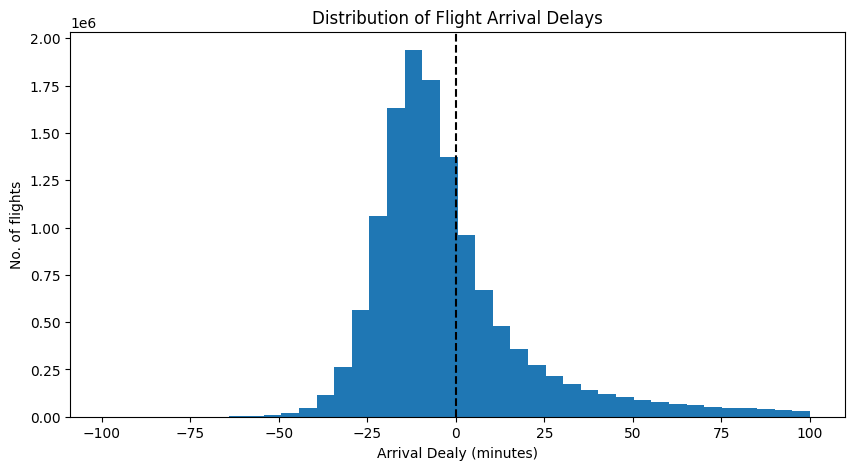

In [31]:

# Drop missing values just in case
arr_delay = df['ArrDelay'].dropna()

# filtering arr_delay for flights no earlier than 100 minutes and no later than 100 mins delayed
arr_delay = arr_delay[( arr_delay >= -100) & (arr_delay <= 100)]


plt.figure(figsize = (10,5))

plt.hist(arr_delay,bins = 40)
plt.axvline(0, linestyle='--', color = "black")

plt.xlabel("Arrival Dealy (minutes)")
plt.ylabel("No. of flights")
plt.title("Distribution of Flight Arrival Delays")


### The flight arrival delay distribution is right-skewed, indicating that most flights arrive early or close to on time, with relatively few experiencing severe delays.